In [1]:
# 库文件
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns
import matplotlib.pyplot as plt
# 设置中文字体
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)  # 替换为你的中文字体文件路径


In [35]:
# 读取Excel文件
# excel_path = f"C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\MPC\\高炉\\0数据\\原始数据摘要.xlsx"
# df_sheet = pd.read_excel(excel_path, sheet_name='SI') 
# # df_sheet = pd.read_excel(excel_path, sheet_name='Sheet2') 
# print(df_sheet.columns)


excel_path = f'C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\MPC\\高炉\\0数据\\原始数据摘要.xlsx'
df_sheet = pd.read_excel(excel_path, sheet_name='建模') 
# print(df_sheet.info())
print(df_sheet.columns)


Index(['铁口1时间戳', '铁口1温度', '铁水时间戳', 'P', '时间戳', 'SI', '主参数时间戳', '富氧率', '透气性指数',
       'CO', 'H2', 'CO2', '标准风速', '富氧流量', '冷风流量', '鼓风动能', '炉腹煤气量', '炉腹煤气指数',
       '理论燃烧温度', '顶压', '富氧压力', '冷风压力', '全压差', '热风压力', '实际风速', '热风温度', '顶温东北',
       '顶温西南', '顶温西北', '顶温东南', '阻力系数', '鼓风湿度', '设定喷煤量', '上小时喷煤量'],
      dtype='object')


In [6]:
print(np.sum(df_sheet['时间差'].values<0.1)/len(df_sheet['时间戳'].values))
print(np.sum(df_sheet['时间差'].values<0.2)/len(df_sheet['时间戳'].values))
print(np.sum(df_sheet['时间差'].values<0.3)/len(df_sheet['时间戳'].values))
print(np.sum(df_sheet['时间差'].values<0.4)/len(df_sheet['时间戳'].values))


0.10258584145824502
0.21237812632471387
0.33955065705807547
0.5158965663416702


In [36]:
input_term = '铁口1温度'
d_time = '时间差'
time_term = '铁口1时间戳'



In [38]:
# 数据归一化、逆归一化
from sklearn.preprocessing import MinMaxScaler

# 将数据存储为字典，每个键对应一列数据
original_data_dict = {
    input_term  :   df_sheet[input_term].values  
    # d_time      :   df_sheet[d_time].values
}

# 初始化缩放器
scalers = {}

# 进行拟合
for column, data in original_data_dict.items():
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(data.reshape(-1, 1))  # 保证数据是列向量
    scalers[column] = scaler

# 进行归一化
normalized_data_dict = {}
for column, scaler in scalers.items():
    normalized_data_dict[column] = scaler.transform(original_data_dict[column].reshape(-1, 1)).flatten()

# 进行反归一化
original_data_dict = {}
for column, scaler in scalers.items():
    original_data_dict[column] = scaler.inverse_transform(normalized_data_dict[column].reshape(-1, 1)).flatten()


In [40]:
df = pd.DataFrame()
df[time_term] = df_sheet[time_term][:]
df[input_term] = normalized_data_dict[input_term][:]

# df = df.dropna() # 删除含有缺失值的行

# 3. 设定索引
df = df.set_index([time_term])

# 4. 检查数据排序
df = df.sort_index()
df


,铁口1温度
铁口1时间戳,
1040,0.126579
1041,0.137362
1042,0.154371
1043,-0.263369
1044,-0.289671
...,...
2001,-0.762238
2002,-0.649015
2003,-0.582116


In [41]:

df


,铁口1温度
铁口1时间戳,
1040,0.126579
1041,0.137362
1042,0.154371
1043,-0.263369
1044,-0.289671
...,...
2001,-0.762238
2002,-0.649015
2003,-0.582116


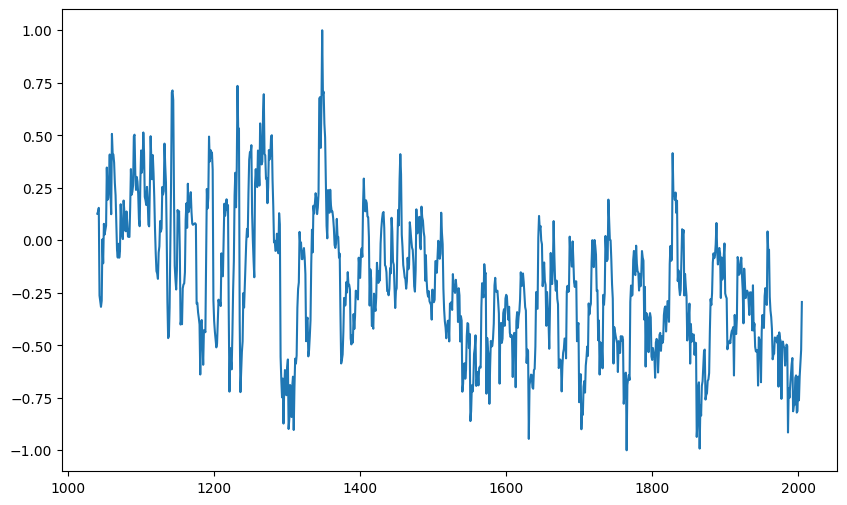

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(df[input_term])
plt.show()


In [43]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df[input_term])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -5.284510
p-value: 0.000006
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568


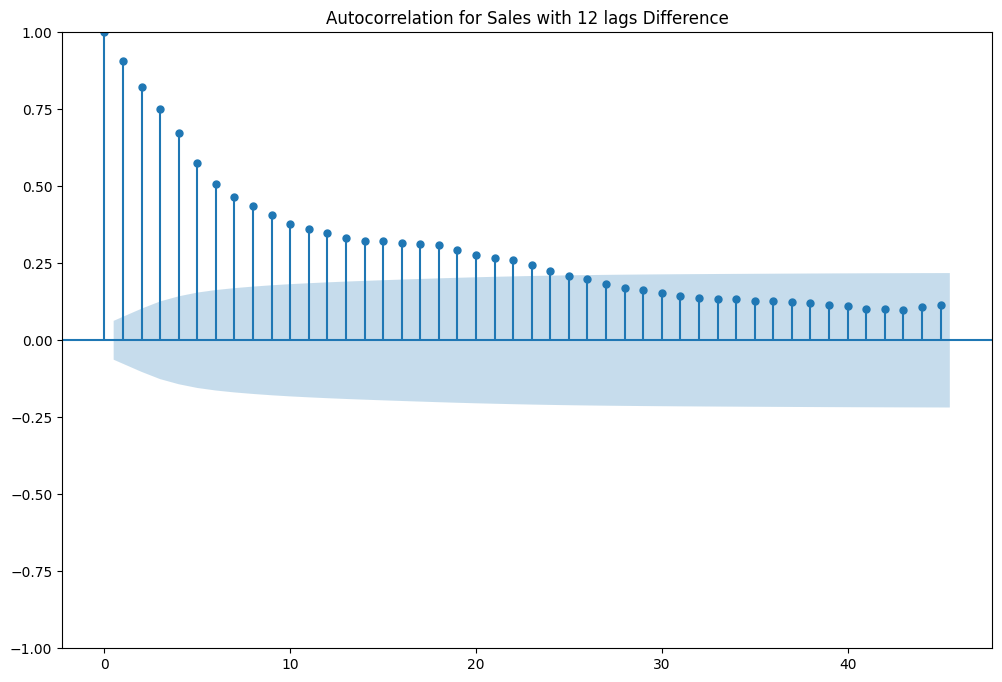

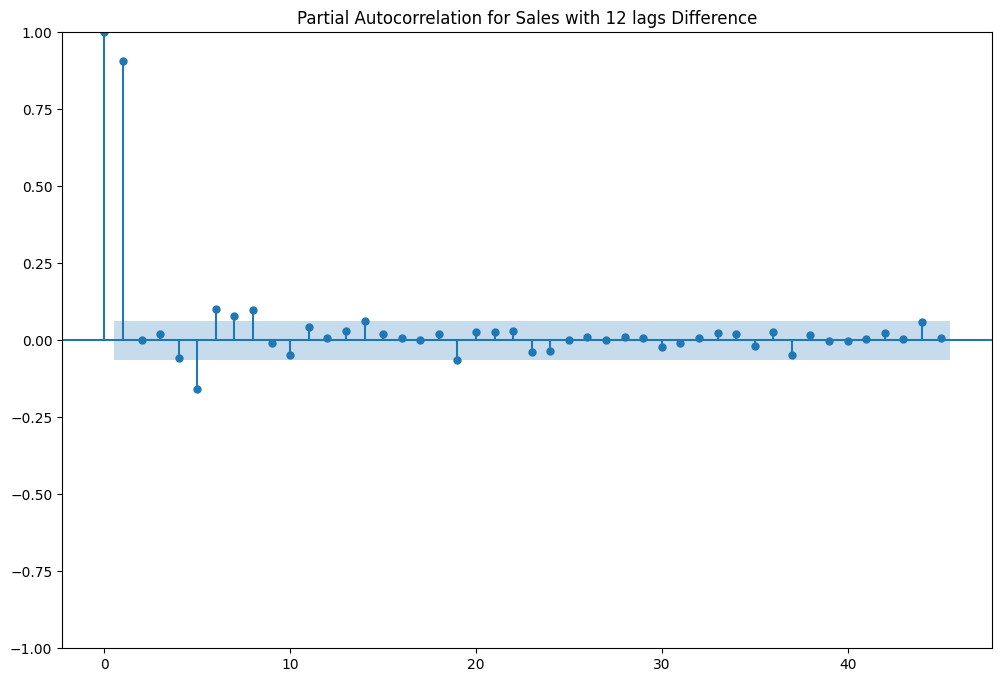

In [44]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 绘制ACF图
plt.figure(figsize=(12,8))
plot_acf(df[input_term].dropna(), lags=45, ax=plt.gca())
plt.title('Autocorrelation for Sales with 12 lags Difference')
plt.show()

# 绘制PACF图
plt.figure(figsize=(12,8))
plot_pacf(df[input_term].dropna(), lags=45, ax=plt.gca())
plt.title('Partial Autocorrelation for Sales with 12 lags Difference')
plt.show()


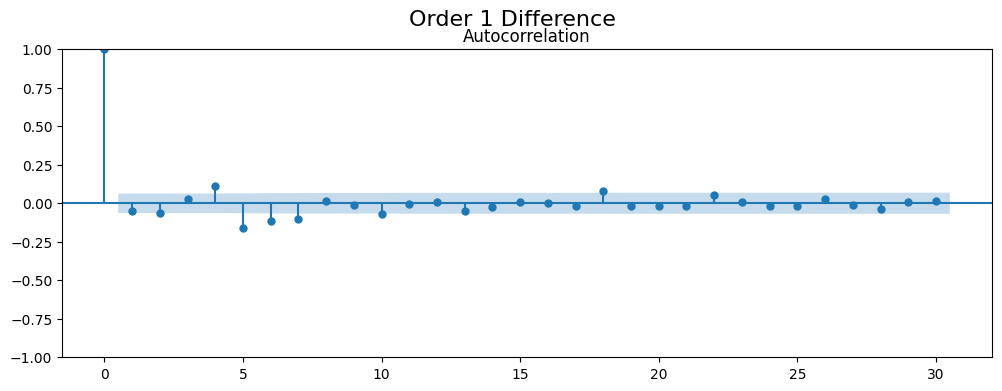

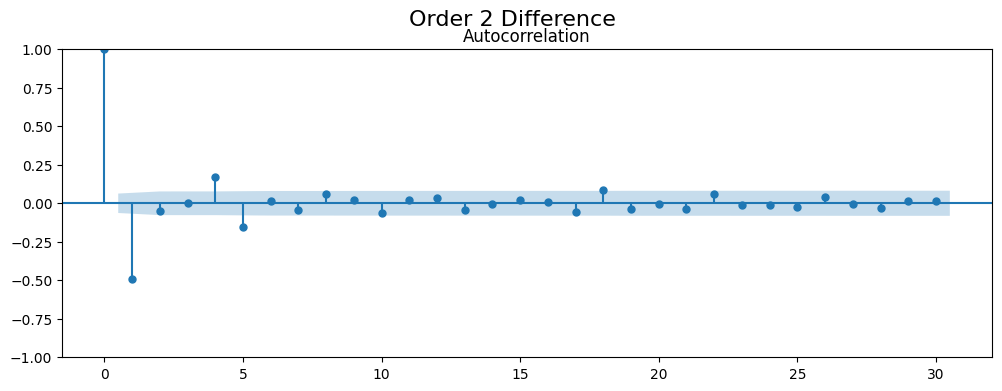

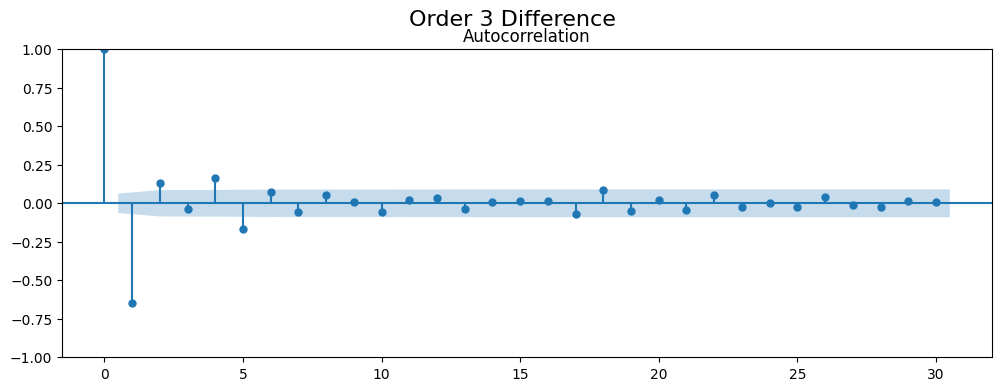

In [45]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import numpy as np

def diff(data, order):
    if order == 0:
        return data
    else:
        return diff(data.diff().dropna(), order - 1)

# 循环不同的d值
for d in range(1, 4):
    # 创建新的图形
    plt.figure(figsize=(12, 4))
    plt.suptitle(f'Order {d} Difference', fontsize=16)

    # 绘制ACF图
    plot_acf(diff(df[input_term], d), ax=plt.gca(), title='Autocorrelation')
    plt.show()


In [46]:
df.index


Index([1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049,
       ...
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005],
      dtype='int64', name='铁口1时间戳', length=966)

In [47]:
# 假设 'df' 是带有 DatetimeIndex 的 DataFrame
# df.index = pd.DatetimeIndex(df.index.values)



In [48]:
# df.index = pd.DatetimeIndex(df.index.values, freq=df.index.inferred_freq)


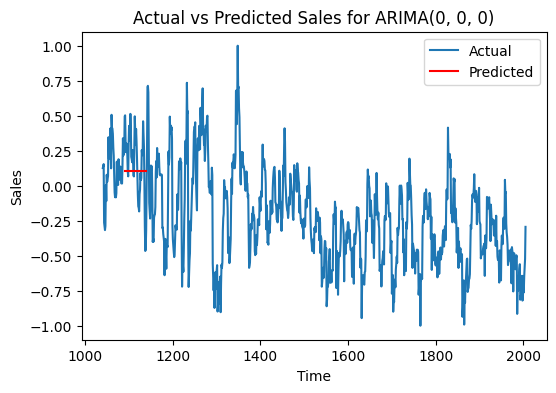

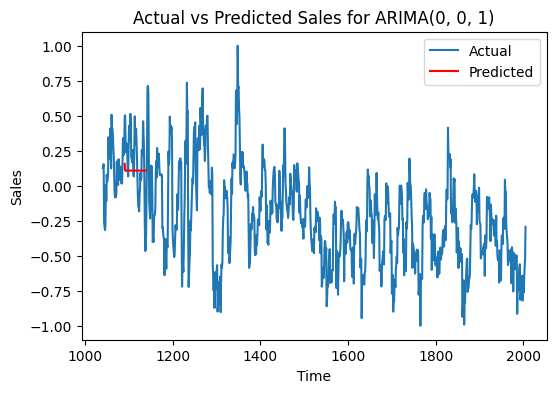

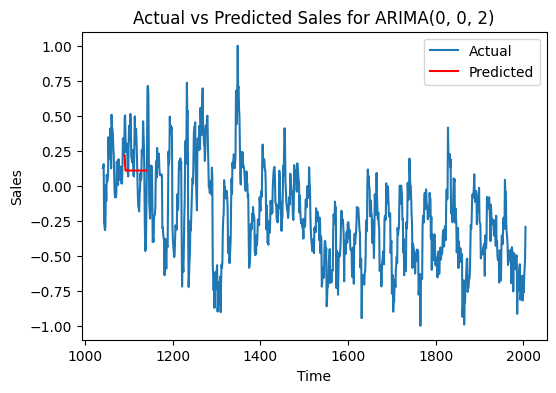

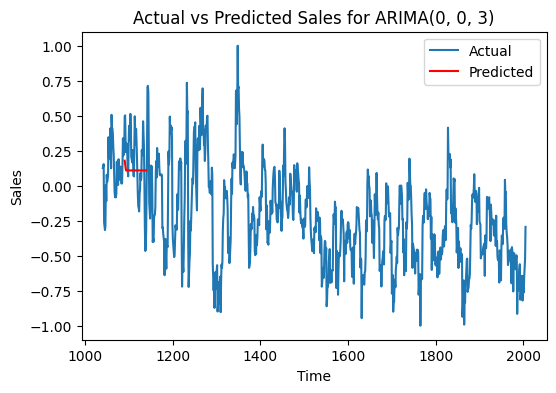

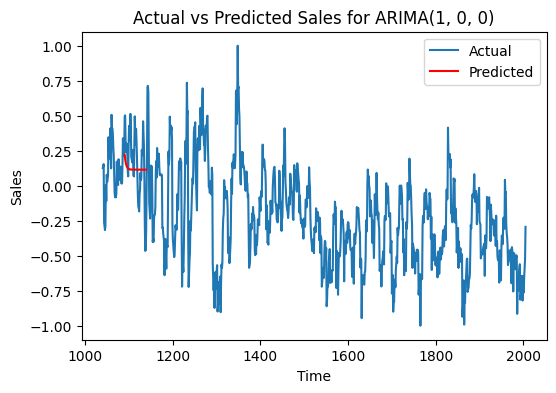

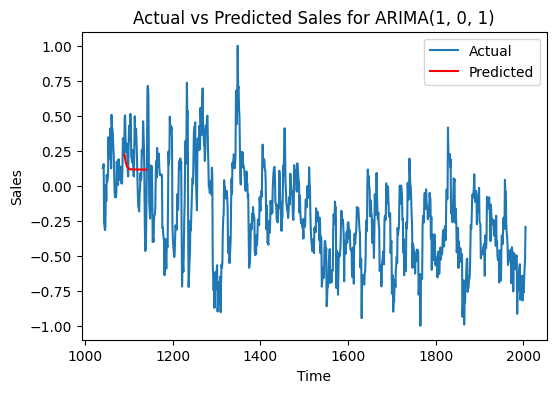

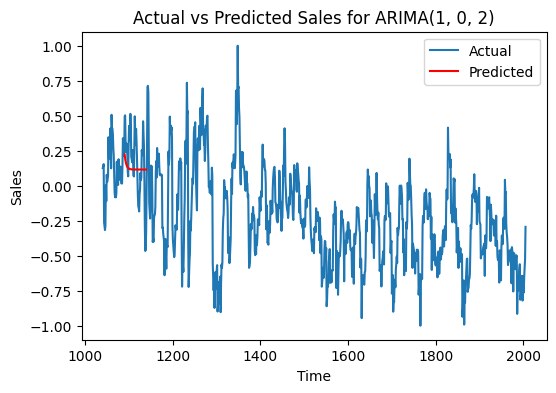

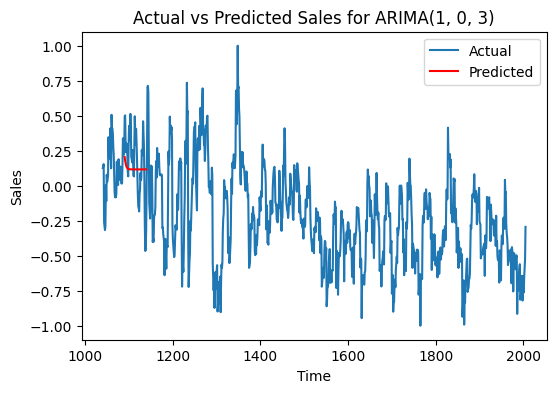

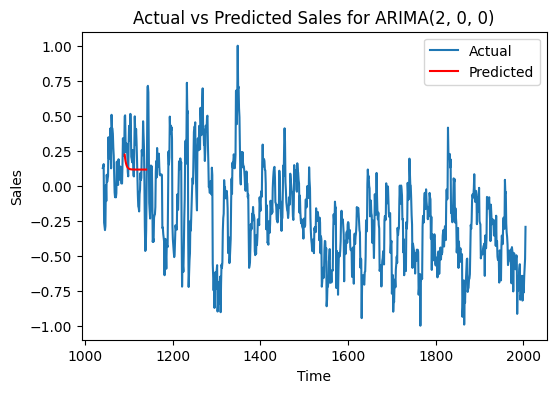

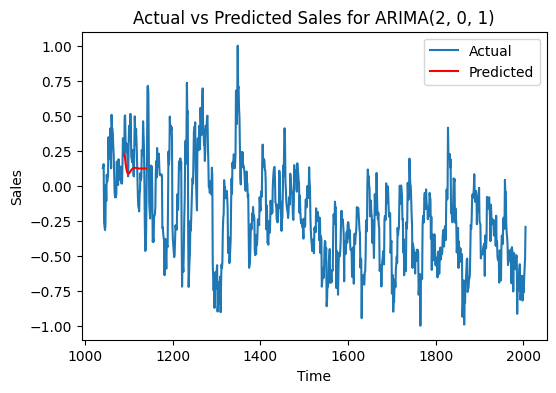

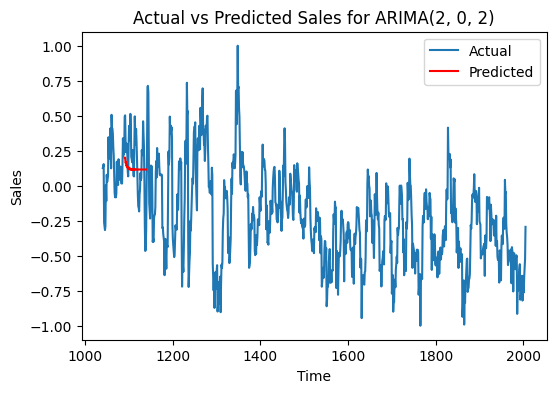

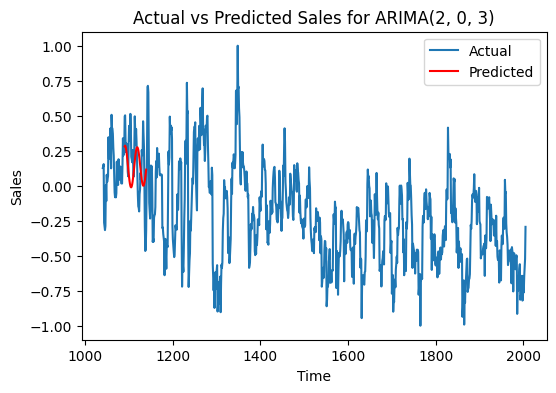

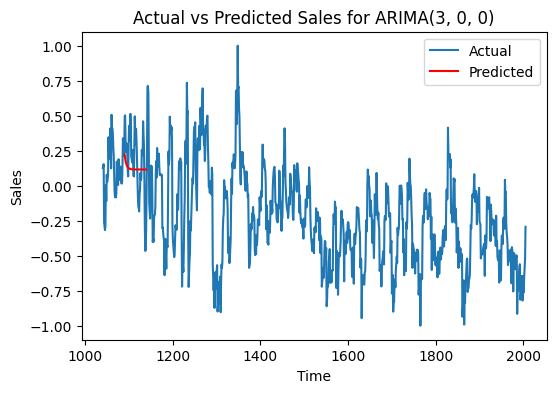

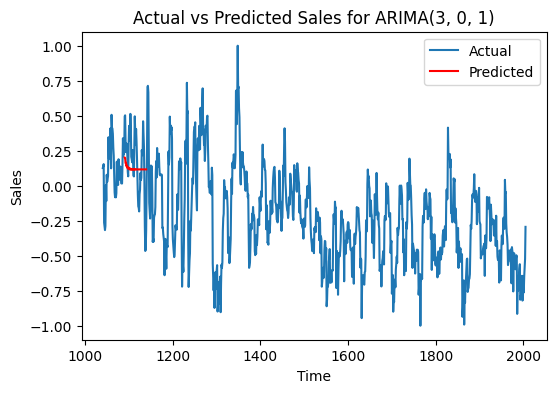

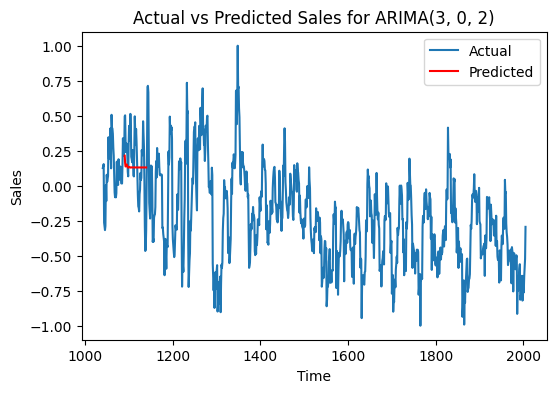

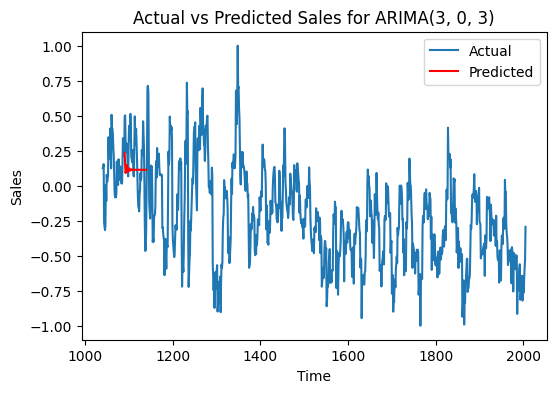

The best model is ARIMA(3, 0, 0), MSE = 0.055250113510515
                               SARIMAX Results                                
Dep. Variable:                  铁口1温度   No. Observations:                   50
Model:                 ARIMA(3, 0, 0)   Log Likelihood                  32.909
Date:                Wed, 24 Jan 2024   AIC                            -55.817
Time:                        15:58:46   BIC                            -46.257
Sample:                             0   HQIC                           -52.177
                                 - 50                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1161      0.072      1.605      0.109      -0.026       0.258
ar.L1          0.6972      0.174      4.004      0.000       0.356       

In [49]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import itertools

#定义p, d和q参数，取0到4之间的任意值
import itertools

p = q = range(0, 4)

# 生成p, d和q三元组的所有不同组合
pdq = [(x[0], 0, x[1]) for x in list(itertools.product(p, q))]



# 将数据分为训练集和测试集
train_data = df[input_term].iloc[:50]
test_data = df[input_term].iloc[50:100]


# 初始化最佳模型及其参数和MSE值
best_model = None
best_param = None
best_mse = float('inf')

# 对每一种参数组合进行迭代
for param in pdq:
    try:
        # 实例化ARIMA模型
        model = ARIMA(train_data, order=param)
        model_fit = model.fit()

        # 进行预测
        predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

        # 计算MSE
        mse = mean_squared_error(test_data, predictions)

        # 如果当前模型的MSE比最佳MSE小，更新最佳模型、参数和MSE
        if mse < best_mse:
            best_model = model_fit
            best_param = param
            best_mse = mse

        # 绘制真实值和预测值
        plt.figure(figsize=(6, 4))
        plt.plot(df.index, df[input_term], label='Actual')
        plt.plot(df.index[50:100], predictions, color='red', label='Predicted')

        # 添加标题和标签
        plt.title('Actual vs Predicted Sales for ARIMA{}'.format(param))
        plt.xlabel('Time')
        plt.ylabel('Sales')
        plt.legend()

        # 显示图形
        plt.show()

    except Exception as e:
        print('Error:', e)
        continue

# 打印出最优模型的参数及其MSE
print(f'The best model is ARIMA{best_param}, MSE = {best_mse}')

# 打印最优模型的摘要
print(best_model.summary(alpha=0.05))
